# Pitch prediction -- classification

If a batter knows what pitch is coming, he is more likely to be able to hit it or lay off of it. Therefore, if a pitcher's next pitch can be predicted, a massive advantage goes to the batter. I will look into the possibility of pitch prediction in the following notebook.

I will start with importing some standard libraries.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Approach

I will look to predict pitches by using as few features as possible. Thus, I will begin by selecting raw features in the database based on human intuition. I intend to only turn to feature engineering if results are poor.

I intend to predict pitches using random forest. This approach has the advantages that it can display both low bias and low variance if results from a large number of decision trees are averaged. Additionally, random forest has a track record of good performance, can handle both regression and classification problems, and can also rank features based on influence on the response. Some drawbacks are that this approach can take up a lot of memory if the size of the dataset and the number of trees is large, and the forests themselves are a bit of a black box in terms of interpretability. Additionally, each pitcher is treated individually since each pitcher will have different pitch tendencies.

For the particular problem of pitch prediction, there are two possible responses that could be used: a categorical response that describes the pitch type (e.g., four-seam fastball, curveball, slider, etc.), or a numerical response that describes the trajectory of the ball (e.g., velocity and vertical/horizontal acceleration).

Ideally, there would be reliable pitch-type labels so that noise in the response that's being predicted would be limited. For example, noise from slightly different trajectories of the same pitch would be limited by classifying them as the same pitch. Additionally, this approach would have a simple baseline metric from which to test my model against: does the model perform better than guessing the most commonly thrown pitch type every pitch? However, from previous work with pitch classification, I concluded that all pitch-type labels should be taken with caution. For instance, the difference between a two-seam and a four-seam fastball can be subjective, and the number of pitches in a pitcher's repertoire is also subjective. One option is to group all pitches into two labels: fastball and off-speed. While this approach would limit the number of misclassified pitches, it also fails to fully exploit the wealth of pitch trajectory information in the database.

Alternatively, I could fully utilize the information in the database and try to predict the trajectory of the next pitch. From my pitch classification work, it appeared that velocity and acceleration were the most important features for separating pitch type, making them candidates for prediction. This approach, however, would be sensitive to noise in the data. Again, a given pitch type is not executed perfectly every time, resulting in a range of trajectories. I am not interested so much in fitting the exact pitch trajectory of the next pitch as I am in estimating an approximate pitch trajectory that allows the hitter to distinguish between pitch types. This approach has the additional challenge that it is difficult to specify a baseline metric to test my model against. Would I just guess the average trajectory of all pitch types every pitch?

Therefore, I propose to use a hybrid approach of the two potential responses: predict how the next pitch falls into bins of velocities and accelerations. So instead of pitches being labeled by pitch type, they will have three labels related to velocity and acceleration bins. Each label type (velocity, vertical and horizontal acceleration) will be split into bins (or categories). For instance, velocity could be split into bins of 70-, 70-80, 80-90, and 90+ mph (these could be different values depending on the pitcher). By predicting which bin the next pitch falls into for each of the three categories (independently), I am able to utilize the pitch trajectory information directly while limiting the effect of noise in the data at the same time. I would no longer be fitting subjective pitch type labels. For this particular approach, the baseline metric to test my model against could be guessing that every pitch is the bin with the highest pitch density.

## Loading data

Pitch prediction will not only depend on the previous pitch thrown, but also variables such as game situation. Therefore, I will load the *pitchfx*, *events*, and *games* tables in the database as pandas dataframes so that I maintain maximum flexibility. I will focus on Barry Zito again for this study.

In [2]:
# specify database name
dbname = "../../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [3]:
# import classes
sys.path.append('../../src')
from Player import Player

# create player object
bz = Player("Barry Zito", db)

# grab pitches
bz_pitches = bz.pitches(clean=1)
# grab events
bz_events = bz.pitch_events()
# grab games
bz_games = bz.pitch_games()

## Data preprocessing

Feature selection can sometimes be more art than science. Here, I will prepare a subset of features that intuition suggests will help predict the type of pitch thrown. They are, loosely, the current ball-strike count, the handedness of the batter, and the baserunner situation. I will prepare these features one by one.

### Ball-strike count

Pitchers will likely pitch differently depending on the ball-strike count. For instance, if the count is 0-2 (0 balls, 2 strikes), a pitcher can throw any pitch because he knows he has 3 more tries to get the batter out. On the other hand, if the count is 3-0 (3 balls, 0 strikes), a pitcher will likely throw a pitch he trusts most in terms of command (often a fastball) because the pitcher will oftentimes want to avoid walking the batter.

In terms of how to represent the count as a feature, there are a couple of options: treat the number of balls and the number of strikes independently, or treat each count as its own category. For now, I will treat the number of balls and strikes as independent features because it requires less feature manipulation. Furthermore, I will keep their original values (0-3 for balls, 0-2 for strikes) rather than encode them, as the order of these numbers has meaning.

In [4]:
# create first feature
features = bz_pitches[["pre_balls", "pre_strike"]].reset_index(drop=True)

# print length of vector
print("number of data points: ", features.shape[0])

number of data points:  3079


### Handedness of batter

The next pitch is also likely influenced by the handedness of the batter. For example, certain pitches are more effective when the pitcher handedness and batter handedness match (such as a breaking ball), and are thus more likely to be thrown.

To get the handedness of the batter for each pitch, I'll need to join the *pitchfx* table with both the *events* table (to tie the pitch to a batter id) and the *players* table (to tie the batter id to the batter handedness). I will do this all in pandas, which requires me to import the *players* table as a pandas dataframe.

In [5]:
# save players table as pandas data frame
query = """SELECT *
        FROM players
        """
players = pd.read_sql_query(query, db)

I'll perform a sequence of left joins. I'll join the *events* table first to the pitches in order to get the batter information. I will then join that resulting table to the *players* table in order to get the batter handedness. Note that I will only add the columns I need (*player_id* and *bats*) and will need to drop the duplicate player information before joining the tables since the same player will have multiple entries if he plays multiple positions.

In [6]:
# merge tables to get the batter handedness for each pitch
handedness = bz_pitches.merge(bz_events[['game_id', 'event_id', 'batter_id']],
                              left_on=['game_id', 'cur_event'],
                              right_on=['game_id', 'event_id'],
                              how='left') \
                       .merge(players[['player_id', 'bats']].drop_duplicates(),
                              left_on='batter_id',
                              right_on='player_id',
                              how='left') \
                       .sort_values(by=['game_id', 'cur_event'])['bats']
        
# print length of vector
print("number of data points: ", handedness.shape[0])

number of data points:  3079


There are three different batter handednesses: left, right, and switch. Typically, switch hitters bat with the opposite hand of the pitcher. Therefore, because Zito throws with his left hand, I will change all switch hitters to bat right-handed here.

Furthermore, *sklearn* assumes all inputs are numerical and continuous. Therefore, I need to choose a method to convert categorical variables to numerical variables. In general, there are a number of possible approaches, including:

1) numerical encoding (each category is associated with an integer). Pros: simple to implement. Cons: assumes that integers are ordered, and therefore that categories are somehow ordered (which is not always the case).

2) one-hot encoding (each category is effectively a vector of length (number of categories) with zeros everywhere but one entry corresponding to the category). Pros: many methods in *sklearn* and *pandas* can implement this; effectively turns each category into an almost-binary value; shown to have better performance than numerical encoding. Cons: can increase feature space significantly if variable has a lot of categories; with decision trees, resulting sparsity virtually ensures that continuous variables are assigned higher feature importance; features with more categories are favored.

3) binary encoding (take numerical encoding and express values in binary). Pros: fewer added features than one-hot encoding; good performance like one-hot encoding. Cons: less straight forward to implement.

Since handedness is binary (left or right), I convert the strings into 0 (left) and 1 (right). In some ways this is like one-hot or binary encoding, but requiring only (number of categories)-1 features since if one value is known the other can be inferred.

In [7]:
# print unique entries of batter handedness
print("unique batter handednesses: ", players['bats'].unique())

# update switch hitters in batter handedness based on pitcher's throwing hand
pthrows = bz.info()['throws'].unique()[0]
if pthrows=='L':
    handedness[handedness=='S'] = 'R'
else:
    handedness[handedness=='S'] = 'L'
print("new unique batter handednesses: ", handedness.unique())

# convert to binary
handedness[handedness=='L'] = 0
handedness[handedness=='R'] = 1

unique batter handednesses:  ['L' 'R' 'S']
new unique batter handednesses:  ['R' 'L']


Now add handedness to the *features* data frame.

In [8]:
# add handedness of batter to features (0: left, 1: right)
features['bats'] = handedness

### Baserunner situation

Having baserunners on base can influence the type of pitch thrown. For instance, if there is a runner on first, a pitcher might be more inclined to throw a pitch with downward movement to induce a grounder for a double play.

To represent the baserunning situation, there are a few options. One is to treat each base independently (in other words, have one feature for each base (first, second, third) that is 1 when there is a runner and 0 when there is no runner). Another is to treat each baserunner combination as its own category. Another is to create a feature there higher values indicate more runners on base closer to home (in other words, sum the runners on base where first has weight 1, second has weight 2, and third has weight 4). I will initially list each base independently, tying the *event* table to each pitch.

In [9]:
# get baserunners for each pitch
runners = bz_pitches.merge(bz_events,
                           left_on=['game_id', 'cur_event'],
                           right_on=['game_id', 'event_id'],
                           how='left')[['pre_1b', 'pre_2b', 'pre_3b']]

# convert runners to binary
runners[runners>0] = 1

In [10]:
# append runners to dataframe
features = pd.concat([features, runners], axis=1)

### Pitch outcome

Finally, I need to determine what exactly I will try to predict. As mentioned earlier, I will try to predict velocity and horizontal/vertical acceleration bins for the next pitch. There are two ways to do this. One is to predict each of the three labels individually and then combine them at the end to interpret the resulting pitch (binary relevance method). The other is to predict all three labels at once. While *sklearn*'s random forest can handle both of these label types, I will start by treating each of the three labels independently.

The first step is to create the three sets of labels themselves. This will require a bit of art, as I will need to determine the appropriate bins for each of the labels. The simplest way is to choose the number of bins and scale them for each pitcher. I'll look at the histograms of each of the variables here after adding them to response dataframe.

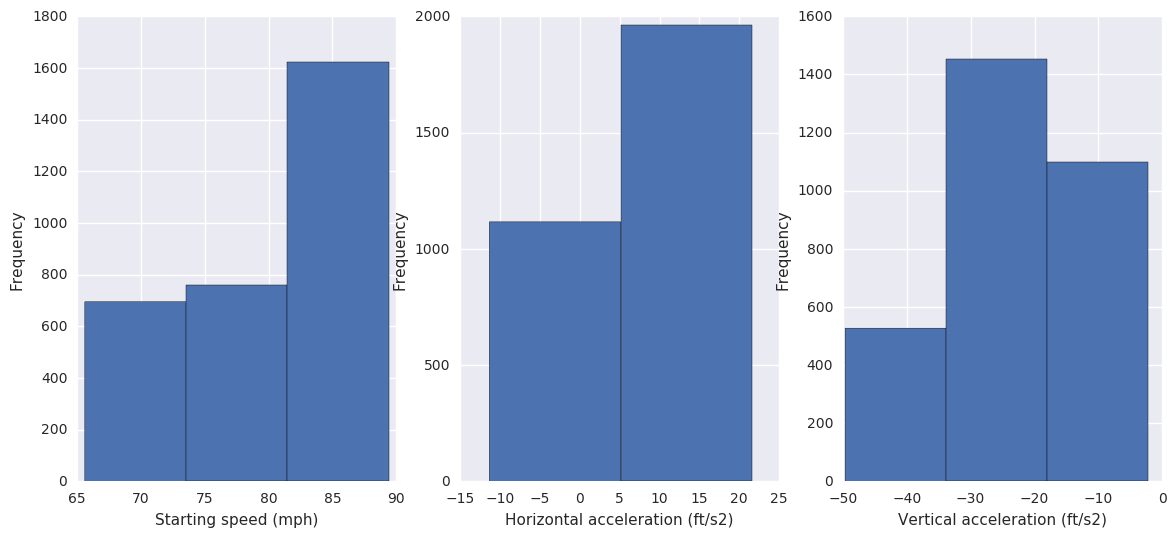

In [11]:
# add parameters to features
response = bz_pitches[["start_speed", "ax", "az"]].reset_index(drop=True)

# set binning parameters
vbins = 3
axbins = 2
azbins = 3

# velocity histogram
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
response['start_speed'].plot.hist(bins=vbins, ax=ax[0])
ax[0].set_xlabel('Starting speed (mph)')
response['ax'].plot.hist(bins=axbins, ax=ax[1])
ax[1].set_xlabel('Horizontal acceleration (ft/s2)')
response['az'].plot.hist(bins=azbins, ax=ax[2])
ax[2].set_xlabel('Vertical acceleration (ft/s2)')
plt.show()

For now, I will go with three bin in two features (speed and vertical accerlation) and two bins in one feature (horizontal acceleration), as shown in the histograms. Though the ranges of each bin are sensitive to outliers, I will assume that many of the outliers along each axis have been removed when cleaning out pitch-outs and intentional balls.

In [12]:
# bin velocity
bin_names = range(vbins)
vlabels, vnames = pd.cut(response['start_speed'], bins=vbins, retbins=True, labels=bin_names)

# bin accelerations
bin_names = range(axbins)
axlabels, axnames = pd.cut(response['ax'], bins=axbins, retbins=True, labels=bin_names)
bin_names = range(azbins)
azlabels, aznames = pd.cut(response['az'], bins=azbins, retbins=True, labels=bin_names)

I'll now plot the bins across the three features.

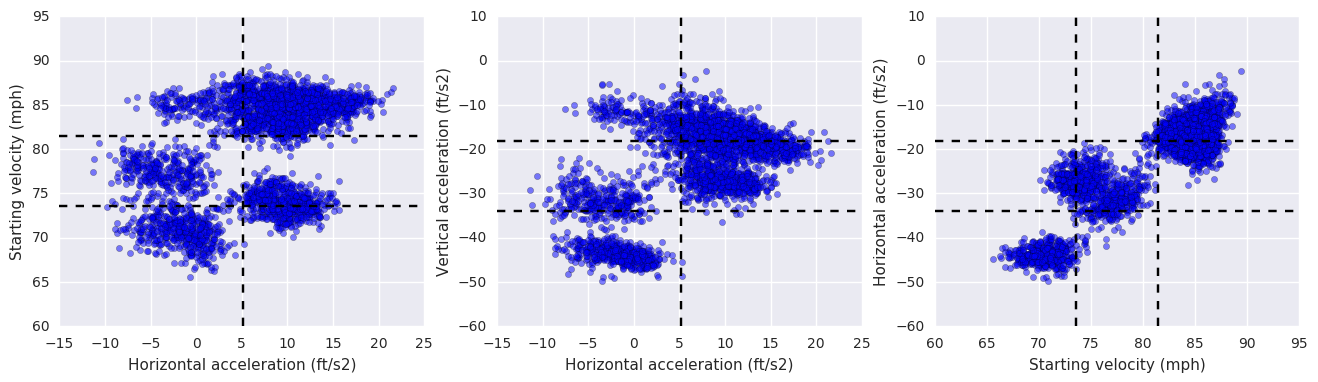

In [13]:
# plot bins with pitch scatter
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# velocity and horizontal acceleration
ax[0].scatter(response['ax'], response['start_speed'], alpha=0.5)
for segments in range(1, len(vnames)-1):
    ax[0].axhline(y=vnames[segments],
                  color='k',
                  ls='dashed',)
for segments in range(1, len(axnames)-1):
    ax[0].axvline(x=axnames[segments],
                  color='k',
                  ls='dashed',)
ax[0].set_xlabel('Horizontal acceleration (ft/s2)')
ax[0].set_ylabel('Starting velocity (mph)')

# vertical and horizontal acceleration
ax[1].scatter(response['ax'], response['az'], alpha=0.5)
for segments in range(1, len(aznames)-1):
    ax[1].axhline(y=aznames[segments],
                  color='k',
                  ls='dashed',)
for segments in range(1, len(axnames)-1):
    ax[1].axvline(x=axnames[segments],
                  color='k',
                  ls='dashed',)
ax[1].set_xlabel('Horizontal acceleration (ft/s2)')
ax[1].set_ylabel('Vertical acceleration (ft/s2)')

# vertical acceleration and velocity
ax[2].scatter(response['start_speed'], response['az'], alpha=0.5)
for segments in range(1, len(aznames)-1):
    ax[2].axhline(y=aznames[segments],
                  color='k',
                  ls='dashed',)
for segments in range(1, len(vnames)-1):
    ax[2].axvline(x=vnames[segments],
                  color='k',
                  ls='dashed',)
ax[2].set_xlabel('Starting velocity (mph)')
ax[2].set_ylabel('Horizontal acceleration (ft/s2)')

plt.show()

These sort of labels could be reasonable, although different types of pitches could easily fall into the same bin. I will go with these labels for now and see how poorly the model performs.

In [14]:
# add labels to response data frame
response['vbin'] = vlabels
response['axbin'] = axlabels
response['azbin'] = azlabels

## check response
#v1 = np.where(np.logical_and(response['start_speed']>vnames[0], response['start_speed']<=vnames[1]))[0]
#v2 = np.where(response['vbin']==0)[0]
#print(sum(v1-v2))

Now that I have a features array and a response array, I can attempt to predict the next pitch using random forest.

## Random forest with basic features

Random forest is a popular ensemble method that averages the results from a number of decision trees grown from bootstrapped data. Here, I will use a random forest classifier (rather than regression) because I want to fit the data into bins (categories).

The first step is to divide the dataset into a training set and a test set. Here, I will start by taking randomly taking 80% of the data to be the training set and the remaining 20% of the data to be the test set. For validating my model, I will look to examine the out-of-bag error.

In [15]:
# generate random indices
np.random.seed(0)
perc_train = 0.8
ndata = features.shape[0]
rand_indices = np.random.choice([True, False], size=ndata, p=[perc_train, 1-perc_train])

In [16]:
# generate test and training sets
X_train = features.loc[rand_indices, :]
X_test = features.loc[~rand_indices, :]
# velocity
Vel_train = response.loc[rand_indices, 'vbin']
Vel_test = response.loc[~rand_indices, 'vbin']
# horizontal acceleration
Ax_train = response.loc[rand_indices, 'axbin']
Ax_test = response.loc[~rand_indices, 'axbin']
# vertical acceleration
Az_train = response.loc[rand_indices, 'azbin']
Az_test = response.loc[~rand_indices, 'azbin']

To check the resulting distributions of each training set, I will again plot the histograms for each category and compare them with the histograms when using all the data.

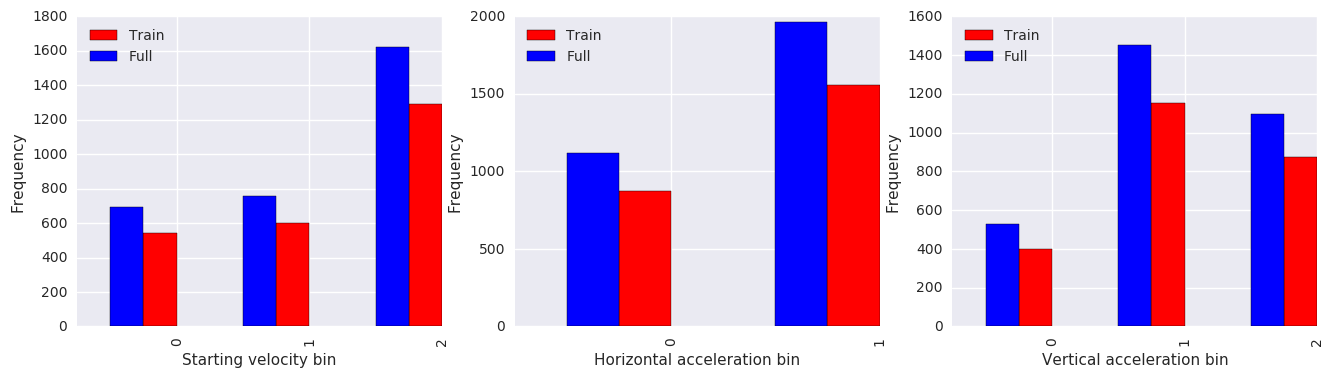

In [17]:
# create bar charts
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# starting velocity
Vel_train.value_counts(sort=False).plot.bar(position=1, color='red', width=0.25, ax=ax[0])
response['vbin'].value_counts(sort=False).plot.bar(position=2, color='blue', width=0.25, ax=ax[0])
ax[0].set_xlabel('Starting velocity bin')
ax[0].set_ylabel('Frequency')
ax[0].legend(('Train', 'Full'), loc=2)

# horizontal acceleration
Ax_train.value_counts(sort=False).plot.bar(position=1, color='red', width=0.25, ax=ax[1])
response['axbin'].value_counts(sort=False).plot.bar(position=2, color='blue', width=0.25, ax=ax[1])
ax[1].set_xlabel('Horizontal acceleration bin')
ax[1].set_ylabel('Frequency')
ax[1].legend(('Train', 'Full'), loc=2)

# vertical acceleration
Az_train.value_counts(sort=False).plot.bar(position=1, color='red', width=0.25, ax=ax[2])
response['azbin'].value_counts(sort=False).plot.bar(position=2, color='blue', width=0.25, ax=ax[2])
ax[2].set_xlabel('Vertical acceleration bin')
ax[2].set_ylabel('Frequency')
ax[2].legend(('Train', 'Full'), loc=2)

plt.show()

It appears that the randomly selecting training set has a similar distribution to the dataset as a whole. No label appears to be sampled too much or too little.

Now that the training data and test data are separated, it's time to run the random forest classifier. I'll use *sklearn*'s implementation.

In [18]:
# import
from sklearn.ensemble import RandomForestClassifier

# initialize parameters
seed = 0
nestimators = 1000

# initialize classifiers
rf_v = RandomForestClassifier(n_estimators=nestimators,
                              criterion='gini',
                              max_features='auto',
                              random_state=seed,
                              oob_score=True,)

rf_ax = RandomForestClassifier(n_estimators=nestimators,
                               criterion='gini',
                               max_features='auto',
                               random_state=seed,
                               oob_score=True,)

rf_az = RandomForestClassifier(n_estimators=nestimators,
                               criterion='gini',
                               max_features='auto',
                               random_state=seed,
                               oob_score=True,)

In [19]:
# fit velocity
rf_v.fit(X_train, Vel_train)
# fit accelerations
rf_ax.fit(X_train, Ax_train)
rf_az.fit(X_train, Az_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

In [20]:
# print out-of-bag errors
print("velocity error: ", 1-rf_v.oob_score_)
print("horizontal acceleration error: ", 1-rf_ax.oob_score_)
print("vertical acceleration error: ", 1-rf_az.oob_score_)

velocity error:  0.4921875
horizontal acceleration error:  0.338404605263
vertical acceleration error:  0.542763157895


I am getting seemingly high error across all levels. I'll now calculate the test error for each response.

In [21]:
# velocity error
print("velocity test error: ", 1-np.mean(rf_v.predict(X_test)==Vel_test))
# acceleration errors
print("horizontal acceleration test error: ", 1-np.mean(rf_ax.predict(X_test)==Ax_test))
print("vertical acceleration test error: ", 1-np.mean(rf_az.predict(X_test)==Az_test))

velocity test error:  0.469860896445
horizontal acceleration test error:  0.332302936631
vertical acceleration test error:  0.539412673879


The test errors are similar to the out-of-bag errors. To give these errors some context, I will calculate two baseline errors. The first is associated with guessing the majority category for each test point (this is similar to a batter "sitting" on a certain pitch).

In [22]:
# import
from scipy.stats import mode

# velocity error
print("baseline velocity error: ", 1-np.mean(Vel_test==mode(Vel_test)[0][0]))
# acceleration errors
print("baseline horizontal acceleration error: ", 1-np.mean(Ax_test==mode(Ax_test)[0][0]))
print("baseline vertical acceleration velocity error: ", 1-np.mean(Az_test==mode(Az_test)[0][0]))

baseline velocity error:  0.485316846986
baseline horizontal acceleration error:  0.375579598145
baseline vertical acceleration velocity error:  0.536321483771


Thus, it appears that the current model is performing better than the baseline model when predicting a velocity range. However, the current model is worse at predicting horizontal acceleration and nearly the same at predicting vertical acceleration compared to guessing the majority category for every pitch.

The other is a Naive Bayes model. Basically, given a new data item, and based on its feature values and training data, pick the highest probability of each possible category using Bayes' theorem. It is an efficient approach because the conditional independence assumption, although this assumption often doesn't hold. I'll use multinomial Naive Bayes since the features are effective counts (not Gaussian or Bernoulli).

In [23]:
# import
from sklearn.naive_bayes import MultinomialNB

# velocity errors
nb_v = MultinomialNB()
nb_v.fit(X_train, Vel_train)
print("naive bayes velocity error: ", 1-np.mean(nb_v.predict(X_test)==Vel_test))
# acceleration errors
nb_ax = MultinomialNB()
nb_ax.fit(X_train, Ax_train)
print("naive bayes horizontal acceleration error: ", 1-np.mean(nb_ax.predict(X_test)==Ax_test))
nb_az = MultinomialNB()
nb_az.fit(X_train, Az_train)
print("naive bayes vertical acceleration error: ", 1-np.mean(nb_az.predict(X_test)==Az_test))

naive bayes velocity error:  0.483771251932
naive bayes horizontal acceleration error:  0.367851622875
naive bayes vertical acceleration error:  0.531684698609


Naive Bayes has nearly the same performance of guessing the majority velocity or acceleration bin for each pitch. Therefore, I will use the error from guessing the majority bin each pitch from this point on.

There are a few possible explanations for the poor performance of the model. One possibility is that the model parameters are not optimized. Others are that the features are not a good indicator of velocity and accelerations of the next pitch.

For the former possibility, I've tried different numbers of features to choose from at each splitting step, as well as a different splitting criterion and found that error rates were very similar (not shown here). To address the latter points, I create a learning curve, which helps determine the bias and variance issues with the model by plotting training and test error rates as a function of number of data points used to create the model. This can help determine whether the model is suffering from high bias or high variance.

In [24]:
# imports
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# create learning curves
cv = 3
# velocity
train_sizes_v, train_scores_v, test_scores_v = learning_curve(rf_v, features, response['vbin'],
                                                              cv=cv, train_sizes=np.linspace(.1, 1.0, 5),)
# accelerations
train_sizes_ax, train_scores_ax, test_scores_ax = learning_curve(rf_ax, features, response['axbin'],
                                                                 cv=cv, train_sizes=np.linspace(.1, 1.0, 5),)
train_sizes_az, train_scores_az, test_scores_az = learning_curve(rf_az, features, response['azbin'],
                                                                 cv=cv, train_sizes=np.linspace(.1, 1.0, 5),)

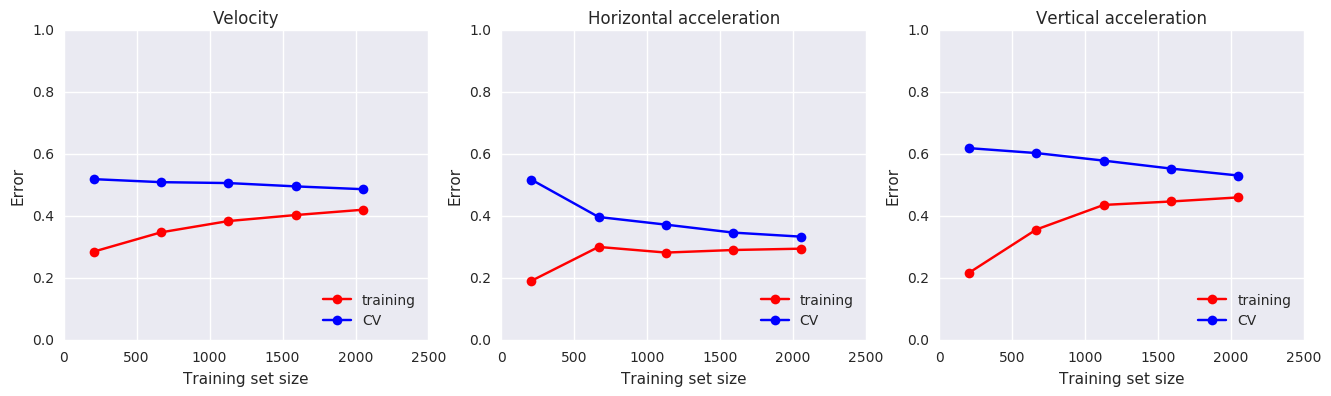

In [25]:
# learning curve figures
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

# velocity
ax[0].plot(train_sizes_v, 1-np.mean(train_scores_v, axis=1), 'o-', color='red')
ax[0].plot(train_sizes_v, 1-np.mean(test_scores_v, axis=1), 'o-', color='blue')
ax[0].legend(['training', 'CV'], loc=4)
ax[0].set_title('Velocity')
ax[0].set_xlabel('Training set size')
ax[0].set_ylabel('Error')
ax[0].set_ylim(0, 1)

# accelerations
ax[1].plot(train_sizes_ax, 1-np.mean(train_scores_ax, axis=1), 'o-', color='red')
ax[1].plot(train_sizes_ax, 1-np.mean(test_scores_ax, axis=1), 'o-', color='blue')
ax[1].legend(['training', 'CV'], loc=4)
ax[1].set_title('Horizontal acceleration')
ax[1].set_xlabel('Training set size')
ax[1].set_ylabel('Error')
ax[1].set_ylim(0, 1)


ax[2].plot(train_sizes_az, 1-np.mean(train_scores_az, axis=1), 'o-', color='red')
ax[2].plot(train_sizes_az, 1-np.mean(test_scores_az, axis=1), 'o-', color='blue')
ax[2].legend(['training', 'CV'], loc=4)
ax[2].set_title('Vertical acceleration')
ax[2].set_xlabel('Training set size')
ax[2].set_ylabel('Error')
ax[2].set_ylim(0, 1)

plt.show()

From all three plots, it is clear that the current model needs refinement (as expected). The training set error is quite high, even when using a smaller training set. Meanwhle, the cross-validation error is relatively constant across all training set sizes, which suggests that the model is generalizing poorly. The model is definitely suffering from high bias (as expected).

I'll look to create a large set of features now to try to decrease the model bias. As reference, I'll look at the most important feature(s) for each label.

In [26]:
# most important features
column_names = features.columns
importance = pd.DataFrame(data=np.array([rf_v.feature_importances_,
                                         rf_ax.feature_importances_,
                                         rf_az.feature_importances_]),
                          columns=column_names,
                          index=['vel', 'ax', 'az']).T

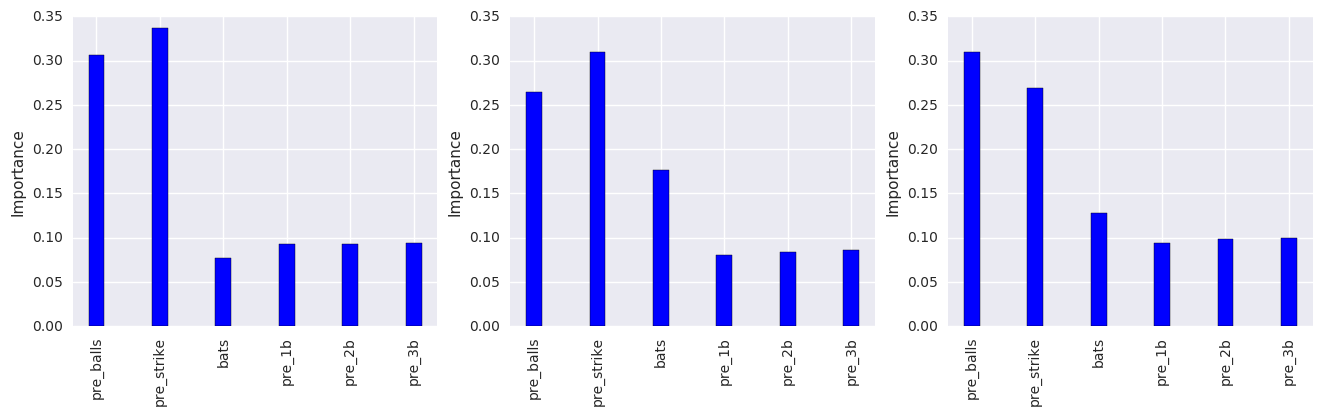

In [27]:
# plot feature importance
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
importance['vel'].plot.bar(color='blue', width=0.25, ax=ax[0])
ax[0].set_ylabel('Importance')
importance['ax'].plot.bar(color='blue', width=0.25, ax=ax[1])
ax[1].set_ylabel('Importance')
importance['az'].plot.bar(color='blue', width=0.25, ax=ax[2])
ax[2].set_ylabel('Importance')
plt.show()

The idea is to measure the decrease in accuracy on OOB data when one randomly permutes the values for that feature. If the decrease is low, then the feature is not important, and vice-versa. Therefore, it appears that the current count is the most important feature. However, note that this could be because the counts of balls and strikes have the most possible values (the other features are binary), and random forest is known to favor features with more categories.

## Bias from features with many categories

Check how biased random forest feature importance is when features have many categories. To do this, create a new table where baserunning is no longer spread across three features but rather is just one feature. A runner on first is weighted 1, and runner on second is weighted 2, and a runner on third is weighted 3.

In [28]:
# drop original baserunner features
features2 = features.drop(['pre_1b', 'pre_2b', 'pre_3b'], axis=1)

In [29]:
# create new baserunning feature
runners = features['pre_1b']+2*features['pre_2b']+4*features['pre_3b']
features2['runners'] = runners

In [30]:
# split into training and test again
X_train2 = features2.loc[rand_indices, :]
X_test2 = features2.loc[~rand_indices, :]

In [31]:
# fit random forest again
# fit velocity
rf_v.fit(X_train2, Vel_train)
# fit accelerations
rf_ax.fit(X_train2, Ax_train)
rf_az.fit(X_train2, Az_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

In [32]:
# print out-of-bag errors
print("velocity error: ", 1-rf_v.oob_score_)
print("horizontal acceleration error: ", 1-rf_ax.oob_score_)
print("vertical acceleration error: ", 1-rf_az.oob_score_)

velocity error:  0.493421052632
horizontal acceleration error:  0.342105263158
vertical acceleration error:  0.541940789474


In [33]:
# velocity error
print("velocity test error: ", 1-np.mean(rf_v.predict(X_test2)==Vel_test))
# acceleration errors
print("horizontal acceleration test error: ", 1-np.mean(rf_ax.predict(X_test2)==Ax_test))
print("vertical acceleration test error: ", 1-np.mean(rf_az.predict(X_test2)==Az_test))

velocity test error:  0.468315301391
horizontal acceleration test error:  0.332302936631
vertical acceleration test error:  0.539412673879


In [34]:
# importances
column_names = features2.columns
importance = pd.DataFrame(data=np.array([rf_v.feature_importances_,
                                         rf_ax.feature_importances_,
                                         rf_az.feature_importances_]),
                          columns=column_names,
                          index=['vel', 'ax', 'az']).T

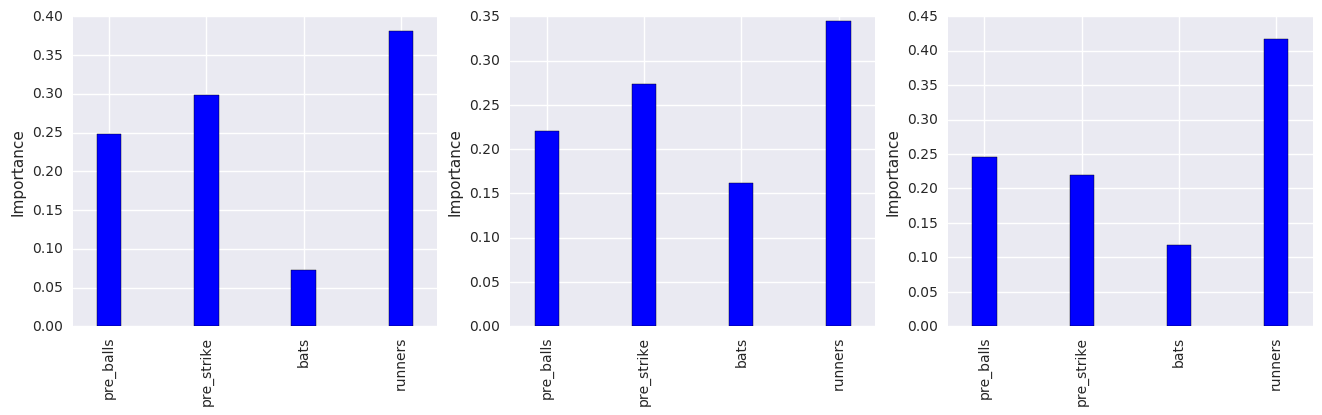

In [35]:
# plot feature importance
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
importance['vel'].plot.bar(color='blue', width=0.25, ax=ax[0])
ax[0].set_ylabel('Importance')
importance['ax'].plot.bar(color='blue', width=0.25, ax=ax[1])
ax[1].set_ylabel('Importance')
importance['az'].plot.bar(color='blue', width=0.25, ax=ax[2])
ax[2].set_ylabel('Importance')
plt.show()

This is a clear example of how feature importance in random forest is biased toward features with more categories. Here, the baserunners went from a number of binary features to one feature with nine categories. More importantly, the test and cross-validation error rates are similar.

## Adding more features

Now I'll add more features and see how the model performs. I'll start by adding more game features: inning, number of outs, and score differential. For the last feature, I'll need to determine whether the pitcher is pitching for the home or away team.

In [36]:
# get game event info
extras = bz_pitches.merge(bz_events,
                          left_on=['game_id', 'cur_event'],
                          right_on=['game_id', 'event_id'],
                          how='left')

# innings
features2['inning'] = extras['inning']

# number of outs
features2['outs'] = extras['pre_out']

# score differential
score_diff = extras['pre_away_score']-extras['pre_home_score']
score_diff[extras['is_top_inning']==True] = -score_diff[extras['is_top_inning']==True]
features2['score_diff'] = score_diff

In [37]:
# training and test data
X_train3 = features2.loc[rand_indices, :]
X_test3 = features2.loc[~rand_indices, :]

In [38]:
# fit random forest again
# fit velocity
rf_v.fit(X_train3, Vel_train)
# fit accelerations
rf_ax.fit(X_train3, Ax_train)
rf_az.fit(X_train3, Az_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=True, random_state=0,
            verbose=0, warm_start=False)

In [39]:
# print out-of-bag errors
print("velocity error: ", 1-rf_v.oob_score_)
print("horizontal acceleration error: ", 1-rf_ax.oob_score_)
print("vertical acceleration error: ", 1-rf_az.oob_score_)

velocity error:  0.508223684211
horizontal acceleration error:  0.360197368421
vertical acceleration error:  0.532072368421


In [40]:
# velocity error
print("velocity test error: ", 1-np.mean(rf_v.predict(X_test3)==Vel_test))
# acceleration errors
print("horizontal acceleration test error: ", 1-np.mean(rf_ax.predict(X_test3)==Ax_test))
print("vertical acceleration test error: ", 1-np.mean(rf_az.predict(X_test3)==Az_test))

velocity test error:  0.510046367852
horizontal acceleration test error:  0.346213292117
vertical acceleration test error:  0.542503863988


In [41]:
# importances
column_names = features2.columns
importance = pd.DataFrame(data=np.array([rf_v.feature_importances_,
                                         rf_ax.feature_importances_,
                                         rf_az.feature_importances_]),
                          columns=column_names,
                          index=['vel', 'ax', 'az']).T

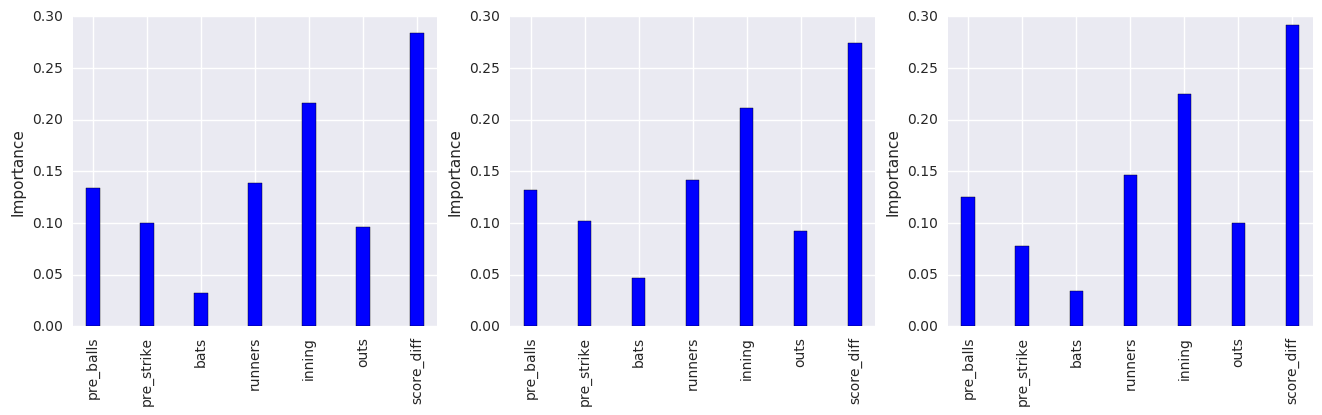

In [42]:
# plot feature importance
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
importance['vel'].plot.bar(color='blue', width=0.25, ax=ax[0])
ax[0].set_ylabel('Importance')
importance['ax'].plot.bar(color='blue', width=0.25, ax=ax[1])
ax[1].set_ylabel('Importance')
importance['az'].plot.bar(color='blue', width=0.25, ax=ax[2])
ax[2].set_ylabel('Importance')
plt.show()

With more situational features, the classifier is still doing worse than guessing the majority occurrance for each response.

Now I'll look to add features related to the pitcher and his previous pitch. In particular, I will add the number of pitches thrown up to that point in the game, the starting velocity of the previous pitch, the accelerations (horizontal and vertical) of the previous pitch, and the call of the previous pitch.

In [43]:
# number of pitches thrown in game
# sort by number of games, find number of pitches per game, then create vector for that game